In [1]:
import fitsio
import proplot as pplt
import numpy as np
import glob
import tqdm
import sys

from mattspy.stats import mad

In [5]:
fnames = glob.glob("./results_wmom_am/meas_mdet_*.fits")

d = []
for fname in tqdm.tqdm(fnames, ncols=79):
    d.append(fitsio.read(fname, ext="data"))
d = np.concatenate(d)

aps = fitsio.read(fname, ext="aps")

sys.stderr.flush()
sys.stdout.flush()
print("# of samples:", d.shape[0])

100%|████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]


# of samples: 483315


In [6]:
def _resample_stat(x, func, n=500, rng=None):
    if rng is None:
        rng = np.random.RandomState()
        
    vals = []
    for _ in range(n):
        vals.append(func(rng.choice(x, size=len(x), replace=True)))
    return func(x), np.std(vals)


def _resample_stat_two(x, w, func, n=500, rng=None):
    if rng is None:
        rng = np.random.RandomState()
        
    vals = []
    for _ in range(n):
        inds = rng.choice(len(x), size=len(x), replace=True)
        vals.append(func(x[inds], w[inds]))
    return func(x, w), np.std(vals)


def _eff_n(w):
    nrm = np.sum(w)
    nrm2 = np.sum(w*w)
    neff = nrm*nrm/nrm2
    return neff

def _eff_var(x, w):
    nrm = np.sum(w)
    nrm2 = np.sum(w*w)
    neff = nrm*nrm/nrm2
    seff = np.sum((x*w)**2)/nrm/nrm / neff
    return seff/neff

max_s2n = 1000
nb = 100
sne = []
frac_kept = []
med_s2n = []
prec = []
rng = np.random
aps_plt = []
eff_n = []
redshifts = []
base_n = []
Rs = []
for i, ap in enumerate(aps):
    if i == 0 or i == 1:
        tcut = 1.2
    else:
        tcut = 0.5
        
    min_s2n = 10
    msk = (
        (d["flags"] == 0)
        & (d["s2n"] > min_s2n)
        & (d["s2n"] < max_s2n)
        & (d["Tratio"] > tcut)
        & (d["mdet_step"] == "noshear")
        & (d["ap"] == i)
    )

    msk_1p = (
        (d["flags"] == 0)
        & (d["s2n"] > min_s2n)
        & (d["s2n"] < max_s2n)
        & (d["Tratio"] > tcut)
        & (d["mdet_step"] == "1p")
        & (d["ap"] == i)
    )

    msk_1m = (
        (d["flags"] == 0)
        & (d["s2n"] > min_s2n)
        & (d["s2n"] < max_s2n)
        & (d["Tratio"] > tcut)
        & (d["mdet_step"] == "1m")
        & (d["ap"] == i)
    )
    
    if (not np.any(msk)) or (not np.any(msk_1p)) or (not np.any(msk_1m)):
        continue
    
    R = (np.mean(d["e1"][msk_1p]) - np.mean(d["e1"][msk_1m]))/0.02
    e1 = d["e1"][msk] / R
    e1_err = d["e1_err"][msk] / R

    
    base_n.append(np.sum(msk))
    aps_plt.append(ap)
    w = 1.0/(e1_err**2 + mad(e1)**2)
    sne.append(_resample_stat(e1, mad, n=nb, rng=rng))
    frac_kept.append(
        _resample_stat(msk, lambda x: np.mean(x), n=nb, rng=rng)
        )
    med_s2n.append(
        _resample_stat(d["s2n"][msk], lambda x: np.percentile(x, 50), n=nb, rng=rng)
    )
    prec.append(_resample_stat_two(e1, w, _eff_var, n=nb, rng=rng))
    eff_n.append(_resample_stat(w, _eff_n, n=nb, rng=rng))
    redshifts.append(
        _resample_stat(d["redshift"][msk], lambda x: np.percentile(x, 50), n=nb, rng=rng)
    )
    Rs.append(R)

frac_kept = np.array(frac_kept)
sne = np.array(sne)
med_s2n = np.array(med_s2n)
prec = np.array(prec)
eff_n = np.array(eff_n)
aps_plt = np.array(aps_plt)
redshifts = np.array(redshifts)
base_n = np.array(base_n)
Rs = np.array(Rs)

print("frac kept", frac_kept[:, 0] * 12)
print("redshifts:", redshifts[:, 0])
print("sne:", sne[:, 0])
print("n_eff:", eff_n[:, 0])
print("R:", Rs[:])
print("shear var:", sne[:, 0]**2/eff_n[:, 0])

frac kept [0.13566308 0.16987679 0.12585581 0.12575649 0.12017008]
redshifts: [1.13883966 1.10967475 1.12436688 1.12437868 1.16095233]
sne: [0.24058582 0.26547026 0.23370963 0.23362297 0.21481176]
n_eff: [5182.2905 6606.42   4555.937  4548.9067 4816.6333]
R: [0.3557347  0.70771342 1.32075055 1.31647931 0.73684277]
shear var: [1.11691034e-05 1.06675722e-05 1.19887946e-05 1.19984192e-05
 9.58015510e-06]


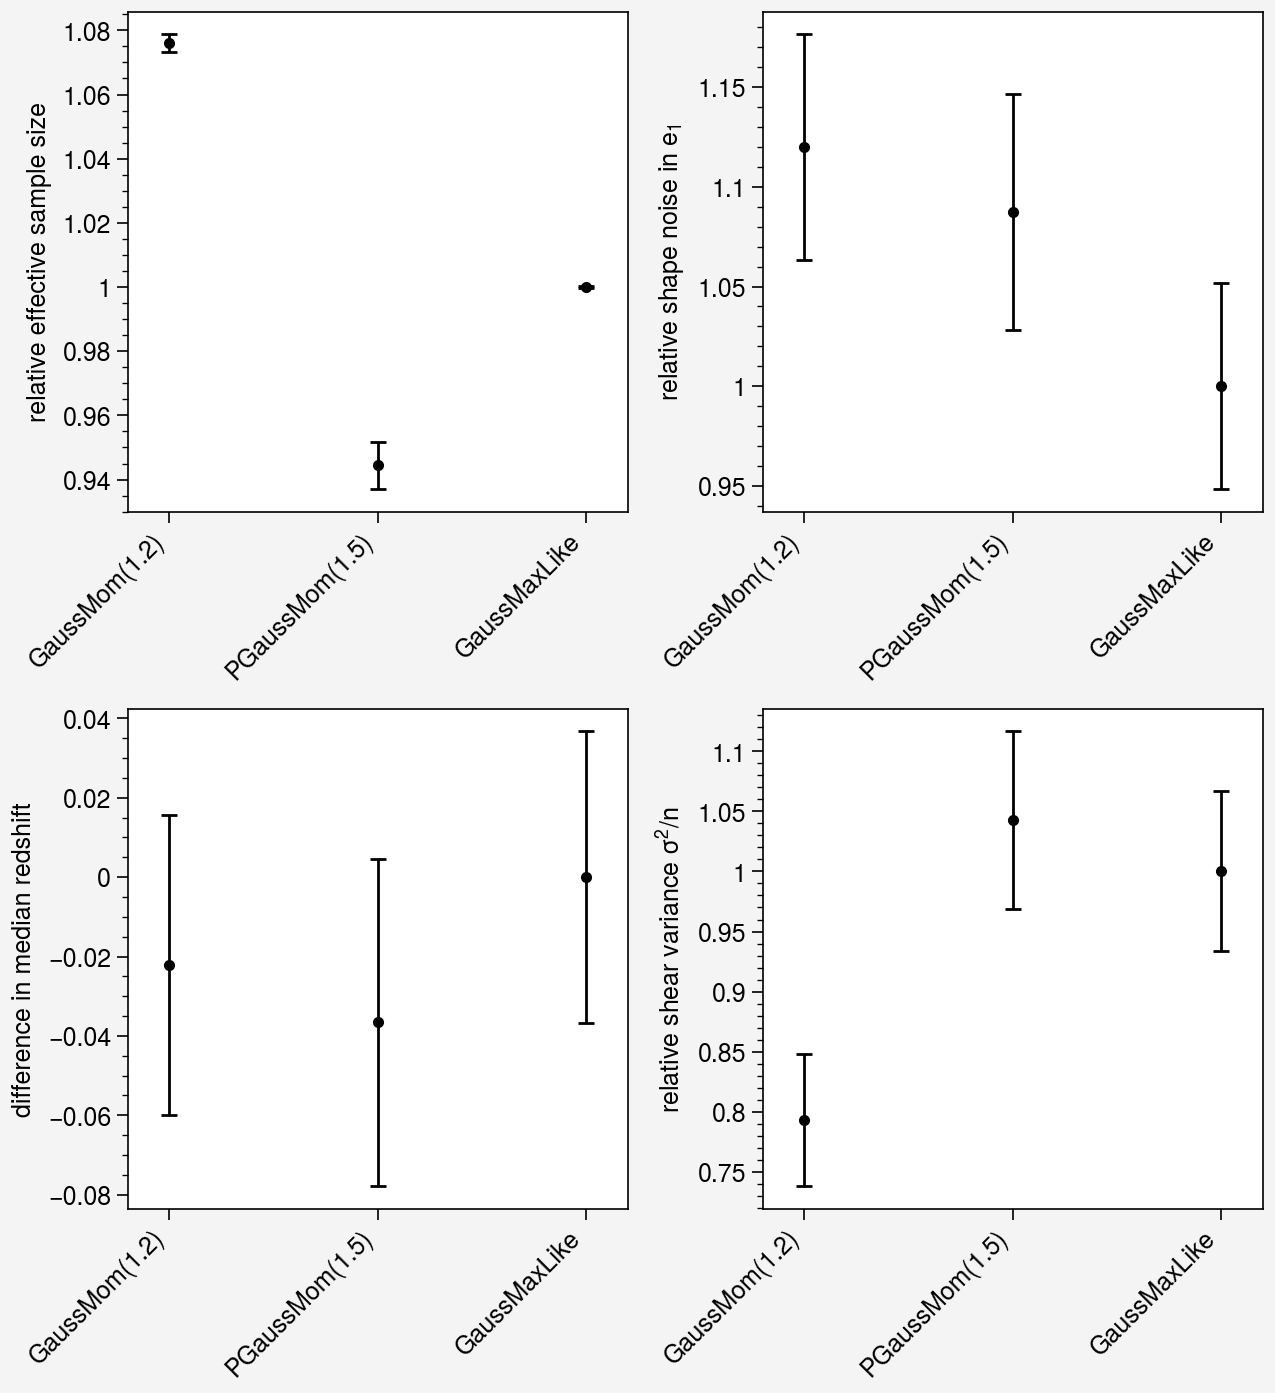

In [7]:
ind = 4
pinds = [0, 3, 4]
kinds = [
    "GaussMom(1.2)",
    "Admom",
    "PrePSF Admom",
    "PGaussMom(1.5)",
    "GaussMaxLike",
]

def _errplot(ax, ar, hval=1):
    x = np.arange(len(pinds))
    ax.plot(
        x,
        ar[:, 0],
        '.k',
        bardata=ar[:, 1]*3,
    )
#     ax.fill_between(
#         x,
#         ar[:, 0] - ar[:, 1]*3,
#         ar[:, 0] + ar[:, 1]*3,
#         alpha=0.5
#     )
    ax.grid(False)
    ax.set_xlim(-0.2, len(pinds) - 0.8)
    ax.format(
        xformatter=[kinds[_p] for _p in pinds],
        xticks=list(range(len(pinds))),
        xrotation=45,
        xtickminor=False,
    )
#     ax.axhline(hval, color='k', linestyle='dashed', lw=1)
#     ax.axvline(1.5, color='k', linestyle='dashed', lw=1)
#     if hval != 1:
#         yy = 0.05
#         ax.set_ylim(-yy, yy)


fig, axs = pplt.subplots(nrows=2, ncols=2, share=0)

_errplot(axs[0, 0], eff_n[pinds, :]/eff_n[ind, 0])
axs[0, 0].set_ylabel("relative effective sample size")

_errplot(axs[0, 1], sne[pinds, :] / sne[ind, 0])
axs[0, 1].set_ylabel("relative shape noise in $e_1$")

sz = redshifts.copy()
sz[:, 0] = sz[:, 0] - redshifts[ind, 0]
_errplot(axs[1, 0], sz[pinds, :], hval=0)
axs[1, 0].set_ylabel("difference in median redshift")

_errplot(axs[1, 1], prec[pinds, :]/prec[ind, 0])
axs[1, 1].set_ylabel(r"relative shear variance $\sigma^{2}/n$")

fig.savefig("optap_am.pdf")